# Data Science Project Notebook

### Authors: 
  - Hardik Chemburkar - MS in Data Science 
  - Vinoth Kumar - MS in Information Science
### Date: 03/24/2025


In [14]:
# 📦 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
# 2. Load Datasets
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
order_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
payments = pd.read_csv("data/olist_order_payments_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
product_cat_translation = pd.read_csv("data/product_category_name_translation.csv")

In [16]:
# 🔁 3. Merge datasets

# Merge product category translation into products
products = pd.merge(products, product_cat_translation, on='product_category_name', how='left')

# Merge datasets in order
df = pd.merge(orders, order_reviews, on='order_id', how='inner')
df = pd.merge(df, order_items, on='order_id', how='inner')
df = pd.merge(df, payments, on='order_id', how='left')
df = pd.merge(df, products, on='product_id', how='left')

In [17]:
# 🔎 4. Null values check
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_values)

Missing values per column:
 review_comment_title             103440
review_comment_message            67650
order_delivered_customer_date      2471
product_category_name_english      1720
product_category_name              1695
product_name_lenght                1695
product_description_lenght         1695
product_photos_qty                 1695
order_delivered_carrier_date       1235
product_weight_g                     20
product_length_cm                    20
product_height_cm                    20
product_width_cm                     20
order_approved_at                    15
payment_value                         3
payment_installments                  3
payment_type                          3
payment_sequential                    3
freight_value                         0
order_id                              0
price                                 0
shipping_limit_date                   0
customer_id                           0
product_id                            0
order_item_i

In [18]:
# 🧹 5. Data cleaning

# Drop rows with critical missing time-related or payment info
df_cleaned = df.dropna(subset=['order_approved_at', 'order_delivered_customer_date', 'payment_type'])

# Fill missing product categories
df_cleaned['product_category_name_english'] = df_cleaned['product_category_name_english'].fillna("unknown")


In [19]:
# 🧠 6. Feature extraction

# Total price including freight
df_cleaned['price_total'] = df_cleaned['price'] + df_cleaned['freight_value']

# Shipping time (in days)
df_cleaned['shipping_days'] = (
    pd.to_datetime(df_cleaned['order_delivered_customer_date']) -
    pd.to_datetime(df_cleaned['order_approved_at'])
).dt.days

# Remove negative shipping days
df_cleaned['shipping_days'] = df_cleaned['shipping_days'].apply(lambda x: x if x >= 0 else np.nan)

# Fill missing shipping_days with median
df_cleaned['shipping_days'].fillna(df_cleaned['shipping_days'].median(), inplace=True)

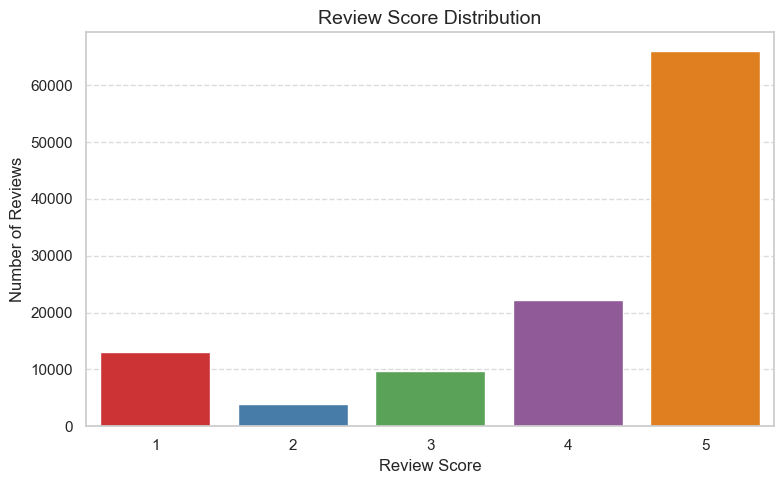

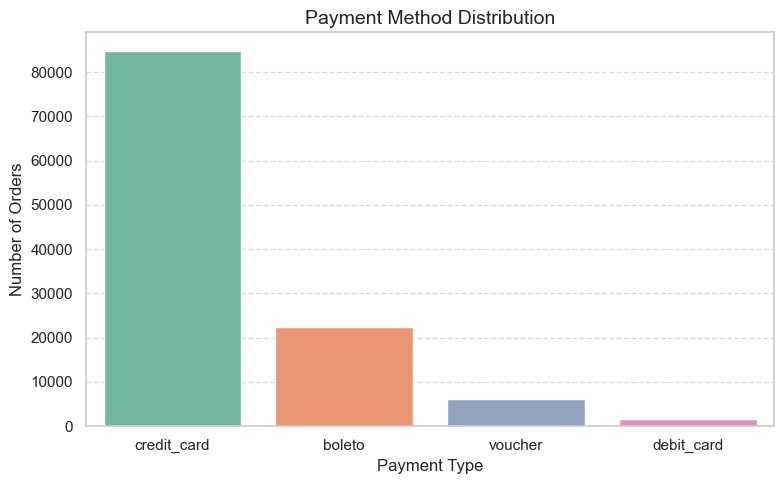

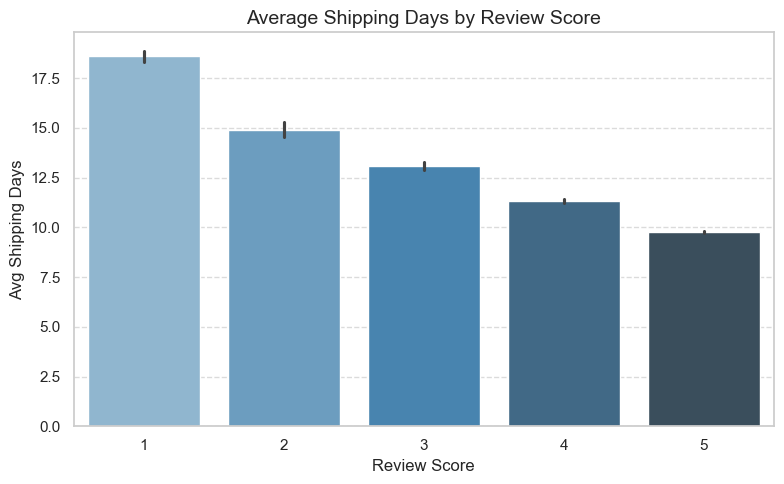

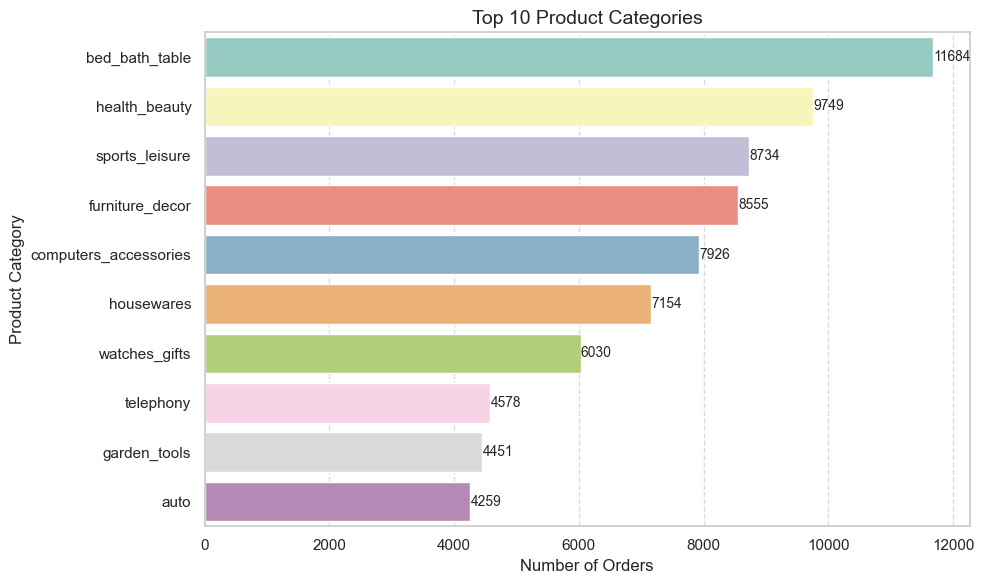

In [22]:
# 📊 7. Visualizations
# Set Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# 1. Review Score Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df_cleaned, x='review_score', palette="Set1")
plt.title("Review Score Distribution", fontsize=14)
plt.xlabel("Review Score", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Payment Method Distribution
plt.figure(figsize=(8,5))
sns.countplot(
    data=df_cleaned, 
    x='payment_type', 
    order=df_cleaned['payment_type'].value_counts().index,
    palette="Set2"
)
plt.title("Payment Method Distribution", fontsize=14)
plt.xlabel("Payment Type", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Average Shipping Days by Review Score
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_cleaned, 
    x='review_score', 
    y='shipping_days', 
    palette="Blues_d"
)
plt.title("Average Shipping Days by Review Score", fontsize=14)
plt.xlabel("Review Score", fontsize=12)
plt.ylabel("Avg Shipping Days", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Top 10 Product Categories
top_cats = df_cleaned['product_category_name_english'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_cats.values, y=top_cats.index, palette="Set3")
plt.title("Top 10 Product Categories", fontsize=14)
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Optional: add value labels
for index, value in enumerate(top_cats.values):
    plt.text(value + 5, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [21]:
# ✅ 8. Extract cleaned features for future use

cleaned_features = df_cleaned[[
    'payment_type',
    'price_total',
    'shipping_days',
    'product_category_name_english',
    'review_score'
]]

# Preview
cleaned_features.head()

,payment_type,price_total,shipping_days,product_category_name_english,review_score
0,credit_card,38.71,8.0,housewares,4
1,voucher,38.71,8.0,housewares,4
2,voucher,38.71,8.0,housewares,4
3,boleto,141.46,12.0,perfumery,4
4,credit_card,179.12,9.0,auto,5


# Feature Engineering 

In [23]:
# 🧩 1. Number of items per order
items_per_order = df_cleaned.groupby('order_id')['order_item_id'].count().reset_index()
items_per_order.columns = ['order_id', 'number_of_items']

# Merge back into cleaned dataset
df_fe = pd.merge(df_cleaned, items_per_order, on='order_id', how='left')

In [24]:
# 🧩 2. Identify repeat customers
customer_order_count = df_fe.groupby('customer_id')['order_id'].nunique().reset_index()
customer_order_count.columns = ['customer_id', 'total_orders']

# Add binary column: is repeat customer
customer_order_count['is_repeated_customer'] = customer_order_count['total_orders'].apply(lambda x: 1 if x > 1 else 0)

# Merge back
df_fe = pd.merge(df_fe, customer_order_count[['customer_id', 'is_repeated_customer']], on='customer_id', how='left')

In [25]:
# 🎯 3. Select useful features
selected_features = df_fe[[
    'payment_type',
    'price_total',
    'shipping_days',
    'product_category_name_english',
    'number_of_items',
    'is_repeated_customer',
    'review_score'
]]

In [26]:
# 🔁 4. One-hot encode categorical variables
df_model = pd.get_dummies(selected_features, columns=['payment_type', 'product_category_name_english'], drop_first=True)

In [27]:
# ✅ 5. Final check before modeling
print("Final shape of dataset:", df_model.shape)
df_model.head()

Final shape of dataset: (114843, 79)


,price_total,shipping_days,number_of_items,is_repeated_customer,review_score,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,product_category_name_english_air_conditioning,product_category_name_english_art,...,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_unknown,product_category_name_english_watches_gifts
0,38.71,8.0,3,0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,38.71,8.0,3,0,4,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,38.71,8.0,3,0,4,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,141.46,12.0,1,0,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,179.12,9.0,1,0,5,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
